# **Prediksi Harga Saham BBRI Menggunakan RNN & LSTM**

---

Kode berikut ini mengimport data saham `BBRI` menggunakan excel, melakukan praproses terlebih dahulu, membangun model **RNN** dan **LSTM**, melakukan pencarian Hyperparameter Tuning dengan `RandomizedSearchCV`, kemudian melatihnya, menyimpan model, dan melakukan plotting antara data training dan data validasi.

## Install Libraries

In [1]:
%pip install numpy pandas scikeras tensorflow matplotlib mplfinance scikit-learn==1.5.0

  Using cached mplfinance-0.12.10b0-py3-none-any.whl.metadata (19 kB)
Using cached mplfinance-0.12.10b0-py3-none-any.whl (75 kB)
Note: you may need to restart the kernel to use updated packages.


## Import Libraries/Ambil Modul

In [1]:
# Import library berkaitan dengan seeding
import os  # Interaksi sistem operasi
import numpy as np  # Komputasi numerik
import random  # Mengatur seed agar hasil konsisten
import tensorflow as tf # Deep learning

# Tetapkan nilai SEED
SEED = 42

#  Atur Seed untuk Semua Library
os.environ['PYTHONHASHSEED'] = str(SEED)  # Menjaga deterministik pada Python
np.random.seed(SEED)  # Untuk NumPy
random.seed(SEED)  # Untuk Python `random`
tf.random.set_seed(SEED)  # Untuk TensorFlow

import pandas as pd # Manipulasi dan analisis data
import math  # Fungsi matematika standar
import sys  # Informasi sistem
import sklearn # Library scikit-learn
import logging  # Modul untuk logging
import matplotlib # Modul utama matplotlib
import time # waktu
from sklearn.preprocessing import MinMaxScaler # Penskalaan data
from tensorflow.keras.models import Sequential # Model sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout  # Layer model
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Callbacks
from sklearn.model_selection import RandomizedSearchCV # Mencari hyperparameter terbaik secara acak
from scikeras.wrappers import KerasRegressor # Model regresi

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Python version: {sys.version}")

TensorFlow version: 2.19.0
NumPy version: 2.1.3
Pandas version: 2.2.3
Scikit-learn version: 1.5.0
Matplotlib version: 3.10.1
Python version: 3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]


## Preprocessing Data

### Data & Visualization


In [2]:
# Menampilkan data saham BBRI
df = pd.read_excel('datasets/BBRI_2010-2025.xlsx')
df

,Date,Open,High,Low,Close,Volume
0,2010-01-04,408.44,411.06,400.59,408.44,125094160
1,2010-01-05,411.06,413.68,408.44,411.06,163644326
2,2010-01-06,405.82,416.29,403.20,405.82,104842810
3,2010-01-07,400.59,405.82,395.35,400.59,101933260
4,2010-01-08,403.20,403.20,395.35,403.20,87237006
...,...,...,...,...,...,...
3696,2024-12-20,3723.15,3768.88,3704.85,3714.00,252689600
3697,2024-12-23,3778.03,3851.21,3759.74,3851.21,167689800
3698,2024-12-24,3860.36,3887.81,3814.62,3842.07,199536100
3699,2024-12-27,3875.15,3894.05,3856.24,3875.15,143104400


### Grafik Candlestick Saham BBRI : (Open, High, Low, Close, Volume)

In [ ]:
# ------------------- FORMAT DAN VALIDASI DATA -------------------
# Memilih kolom date sebagai index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

required_columns = ['Open', 'High', 'Low', 'Close']
if not all(col in df.columns for col in required_columns):
    raise ValueError("File harus memiliki kolom: Open, High, Low, dan Close")

has_volume = 'Volume' in df.columns

c:\Stock Prediction Using RNN & LSTM (BBRI_2010-2025) 70_15_15\env\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


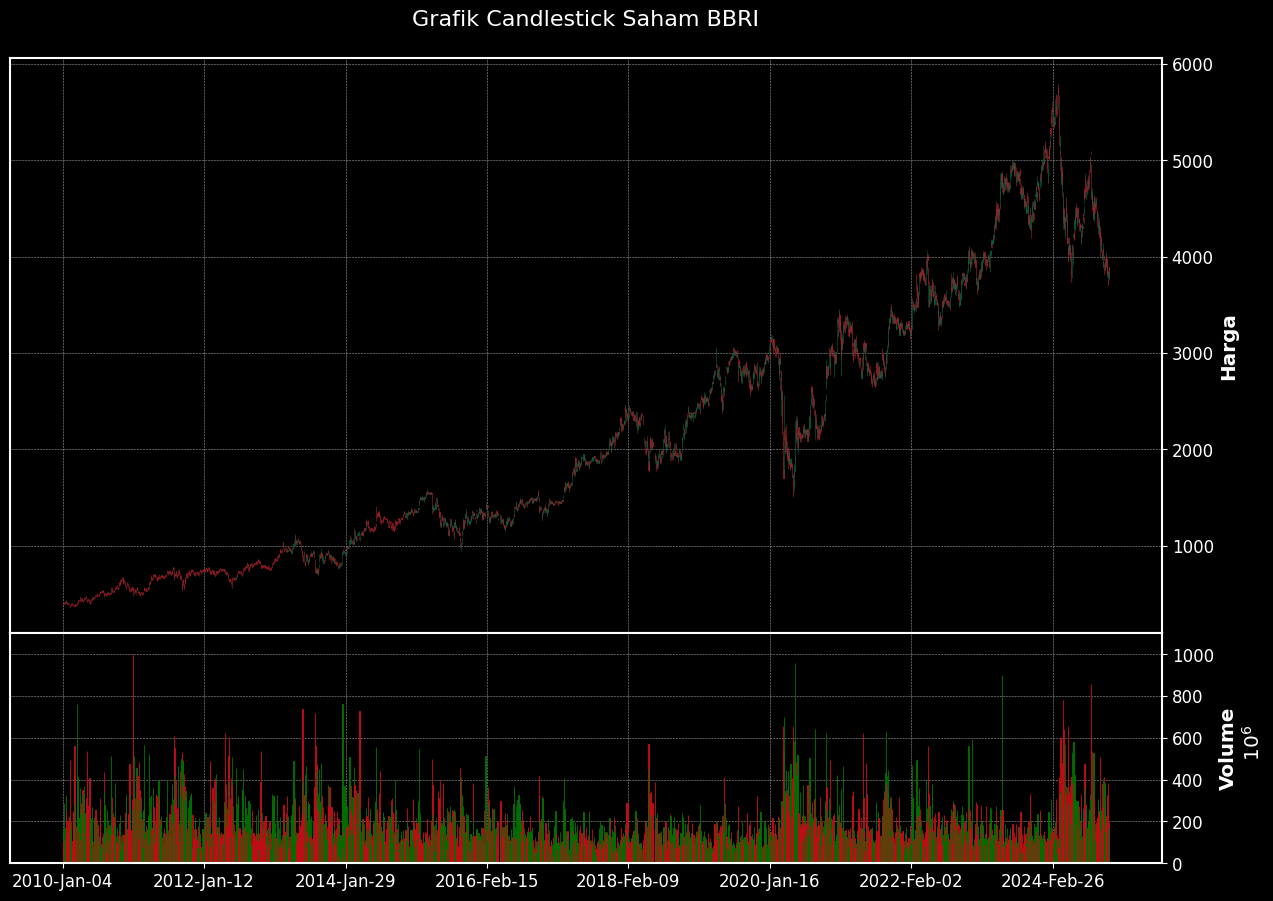

In [ ]:
import mplfinance as mpf # Grafik candlestick dan chart 
import matplotlib.pyplot as plt # Visualisasi grafik 

# Gaya hitam dengan teks putih
style = mpf.make_mpf_style(
    base_mpf_style='charles',
    facecolor='black',
    figcolor='black',
    rc={
        'font.size': 12,
        'text.color': 'white',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'axes.edgecolor': 'white',
    }
)

# -------- Grafik 1: Semua data --------
# Plot dan ambil figure + axes
fig, axes = mpf.plot(
    df,
    type='candle',
    style=style,
    ylabel='Harga',
    ylabel_lower='Volume',
    volume=True,
    figscale=2,
    returnfig=True
)

# Tambahkan teks judul di dalam area fig utama (axes[0] = grafik harga)
axes[0].text(
    0.5, 1.05,  # posisi X (tengah), Y (sedikit di atas grafik)
    'Grafik Candlestick Saham BBRI',
    color='white',
    fontsize=16,
    ha='center',
    va='bottom',
    transform=axes[0].transAxes
)

# Atur rotasi tanggal jadi horizontal
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(0)

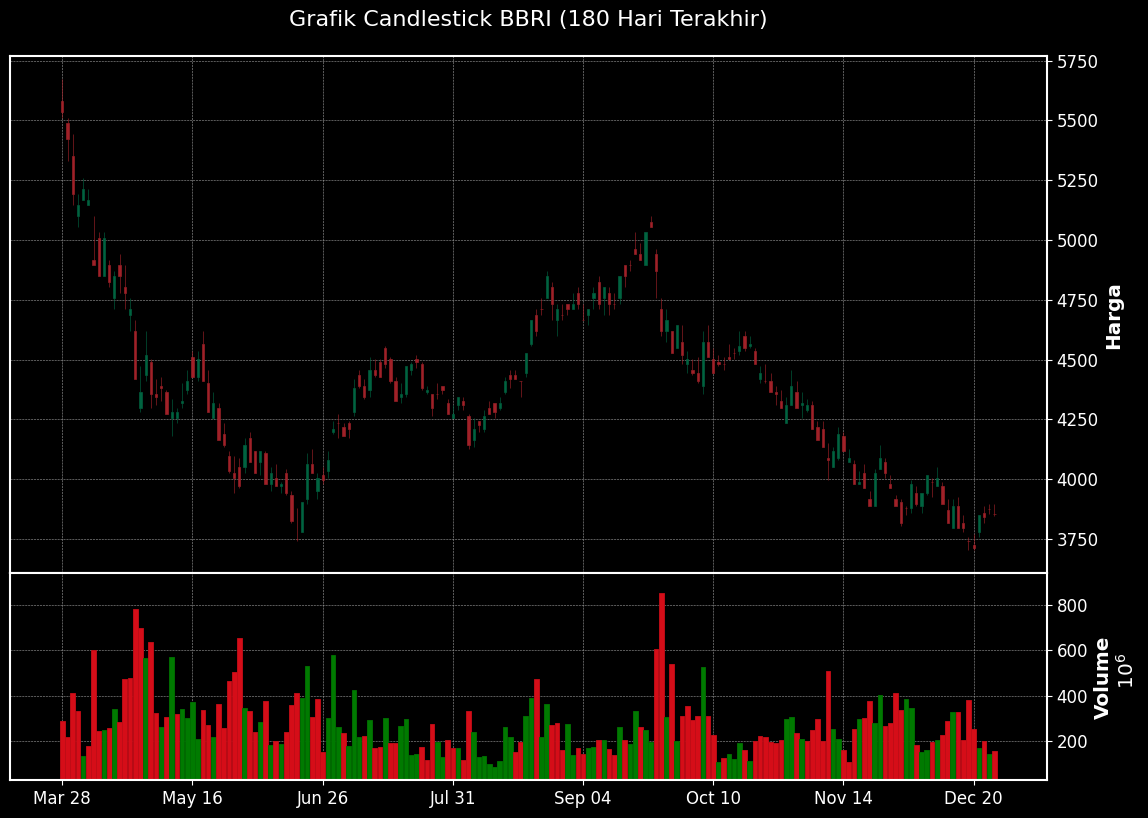

In [5]:
# -------- Grafik 2: 180 Hari Terakhir --------
last_180 = df.tail(180)  # ambil 180 hari terakhir

fig2, axes2 = mpf.plot(
    last_180,
    type='candle',
    style=style,
    ylabel='Harga',
    ylabel_lower='Volume',
    volume=True,
    figscale=1.8,
    returnfig=True
)

axes2[0].text(
    0.5, 1.05,
    'Grafik Candlestick BBRI (180 Hari Terakhir)',
    color='white',
    fontsize=16,
    ha='center',
    va='bottom',
    transform=axes2[0].transAxes
)

for ax in axes2:
    for label in ax.get_xticklabels():
        label.set_rotation(0)

plt.show()

### Close for Prediction

In [ ]:
# Memilih kolom close untuk prediksi
df= df[['Close']]
df

,Close
Date,
2010-01-04,408.44
2010-01-05,411.06
2010-01-06,405.82
2010-01-07,400.59
2010-01-08,403.20
...,...
2024-12-20,3714.00
2024-12-23,3851.21
2024-12-24,3842.07


In [8]:
# Melihat Informasi detail mengenai struktur DataFrame
df.info()
print("\nJumlah Missing Values pada Kolom:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3701 entries, 2010-01-04 to 2024-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3701 non-null   float64
dtypes: float64(1)
memory usage: 57.8 KB

Jumlah Missing Values pada Kolom:
 Close    0
dtype: int64


In [9]:
# Menampilkan statistik deskriptif dari DataFrame
df.describe()

,Close
count,3701.000000
mean,2093.328017
std,1316.272071
min,371.780000
25%,939.000000
50%,1841.300000
75%,2987.700000
max,5763.100000


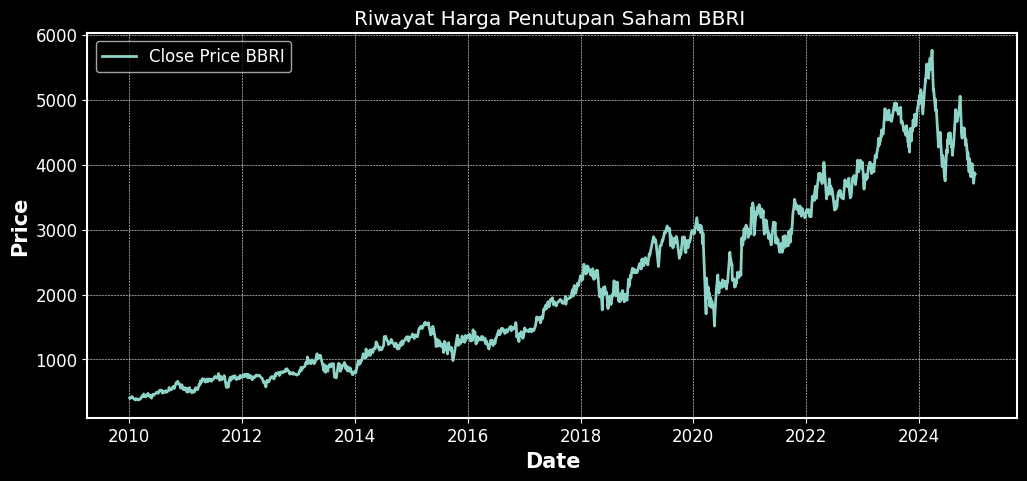

In [11]:
# Visualisasi data harga penutupan
plt.style.use('dark_background')
plt.figure(figsize=(12, 5))
plt.title('Riwayat Harga Penutupan Saham BBRI ')
plt.plot(df['Close'], label='Close Price BBRI')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend()
plt.show()

### Splitting Data : Training, Validation and Testing Data 

Dataset dibagi menjadi set pelatihan `75%`, set validasi `15%`, dan set pengujian`15%`.

In [12]:
# Konversi data ke numpy array, Reshape data ke 2D array
data = df.filter(['Close']).values.reshape(-1, 1)
data, data.shape

(array([[ 408.44],
        [ 411.06],
        [ 405.82],
        ...,
        [3842.07],
        [3875.15],
        [3856.24]]),
 (3701, 1))

In [13]:
# Rasio pembagian data :
length_data = len(data) # Panjang data

# Tentukan jumlah data untuk masing-masing set
train_len = math.ceil(length_data * 0.7)  # 70% data untuk training
val_len = int(length_data * 0.15)   # 15% data untuk validation
test_len = length_data - (train_len + val_len)  # Sisa 15% untuk testing

print("Total Data :", length_data)
print("Training Data  :", train_len)
print("Validation Data :", val_len)
print("Testing Data :", test_len)

Total Data : 3701
Training Data  : 2591
Validation Data : 555
Testing Data : 555


### Data Normalization

Pada langkah ini, saya memisahkan data training, validasi dan testing. Pertama, saya memproses data latih terlebih dahulu. `MinMaxScaler` digunakan untuk menormalisasikan data, menskalakannya ke kisaran antara `0` dan `1`.

In [9]:
# Pembentukan data training
train_set = data[0:train_len]
train_set

array([[ 408.44],
       [ 411.06],
       [ 405.82],
       ...,
       [1904.4 ],
       [2057.87],
       [2218.32]])

In [10]:
# Ubah ke DataFrame agar bisa pakai describe()
train_df = pd.DataFrame(train_set, columns=['Close'])

# Tampilkan statistik deskriptif untuk data training
print("Statistik Deskriptif Data Training:")
print(train_df.describe())

Statistik Deskriptif Data Training:
             Close
count  2591.000000
mean   1390.359421
std     723.050653
min     371.780000
25%     760.900000
50%    1270.030000
75%    1918.810000
max    3182.400000


In [11]:
# Normalisasi data training dengan MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
train_scaled_data = sc.fit_transform(train_set)
train_scaled_data

array([[0.01304339],
       [0.01397556],
       [0.01211121],
       ...,
       [0.54529606],
       [0.59989967],
       [0.65698671]])

### Menentukan Nilai Hyperparamaeter

*   `time_step = 30`                  (Sequence Length/Window Size untuk model memprediksi nilai berikutnya)
*   `n_layers = 1, 2`           (Jumlah lapisan (layer) dalam model)
*   `n_units = 64, 128, 256`             (Jumlah neuron di setiap layer model)
*   `dropout_rate = 0.2, 0.3`      (Persentase neuron dalam layer yang dinonaktifkan secara acak)
*   `epochs = 100`                 (Jumlah siklus penuh pelatihan model terhadap seluruh dataset)
*   `batch_size = 64`           (Jumlah sampel yang diproses sekaligus sebelum update bobot)
*   `optimizer = 'Adam'`                (Algoritma optimasi untuk memperbarui bobot model)
*   `learning_rate = 0.001, 0.0001`             (Kecepatan pembaruan bobot)
*   `loss = 'mse'`                      (Mengukur kesalahan model)



### Sliding Window Technique

In [12]:
# Membuat fungsi untuk pembentukan teknik sliding window
x_train = []
y_train = []

time_step = 30

for i in range(time_step, len(train_scaled_data)):
    x_train.append(train_scaled_data[i-time_step:i, 0])
    y_train.append(train_scaled_data[i, 0])

    if i<= time_step:
      print(x_train)
      print(y_train)
      print()

[array([0.01304339, 0.01397556, 0.01211121, 0.01025041, 0.01117903,
       0.01117903, 0.01397556, 0.01397556, 0.01397556, 0.01304339,
       0.01490774, 0.02049726, 0.0186329 , 0.01490774, 0.01490774,
       0.01304339, 0.00931823, 0.00838605, 0.01025041, 0.01025041,
       0.00838605, 0.00838605, 0.00838605, 0.00558951, 0.00279654,
       0.        , 0.00279654, 0.00093218, 0.00372871, 0.00838605])]
[np.float64(0.009318228718218774)]



In [13]:
# Mengubah tipe data list menjadi numpy array 2D
x_train, y_train = np.array(x_train), np.array(y_train)
print("x_train before reshape :",x_train.shape)
print("y_train before reshape :",y_train.shape)

x_train before reshape : (2561, 30)
y_train before reshape : (2561,)


In [14]:
# Ubah bentuk data menjadi bentuk yang diterima oleh model ke dalam bentuk 3D (Sample, Time_Step, Feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("x_train after reshape :",x_train.shape)
print("y_train after reshape :",y_train.shape)

x_train after reshape : (2561, 30, 1)
y_train after reshape : (2561, 1)


In [15]:
# Pembentukan data validasi dan scalling data
val_set = data[train_len - time_step :(train_len + val_len), :]
val_scaled_data = sc.transform(val_set)

In [16]:
# Buat fungsi pembentukan teknik sliding window seperti sebelumnya
x_val = []
y_val = []

for i in range(time_step, len(val_scaled_data)):
    x_val.append(val_scaled_data[i - time_step:i, 0])
    y_val.append(val_scaled_data[i, 0])

x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
y_val = np.reshape(y_val, (y_val.shape[0],1))

## RNN Model

### Fungsi Membuat Hyperparameter RandomizedSearchCV RNN

In [17]:
# First RNN layer (harus return_sequences=True jika lebih dari 1 layer)
def build_model_RNN(n_units=None, n_layers=None, dropout_rate=None, learning_rate=None): 
    tf.random.set_seed(SEED)
    model = Sequential()
    model.add(tf.keras.Input(shape=(x_train.shape[1], 1)))  # Definisikan input layer

    # Layer pertama harus mempertimbangkan jumlah layer yang ada
    return_seq = True if n_layers > 1 else False
    model.add(SimpleRNN(units=n_units, activation="tanh", return_sequences=return_seq))
    model.add(Dropout(dropout_rate))  # Dropout setelah layer pertama
    
    # Menambahkan additional RNN layers sesuai jumlah layer yang ditentukan
    for i in range(1, n_layers):
        return_seq = i < (n_layers - 1)  # Hanya sebelum layer terakhir pakai return_sequences=True
        model.add(SimpleRNN(units=n_units, activation="tanh", return_sequences=return_seq))
        model.add(Dropout(dropout_rate))  # Dropout setelah setiap RNN layer
    
    # Menambahkan output layer
    model.add(Dense(units=1))

    # Konfigurasi optimizer dan loss function serta compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [18]:
# Membungkus model dalam KerasRegressor dengan parameter yang akan dituning
model_RNN = KerasRegressor(model=build_model_RNN, verbose=0)

# Menentukan ruang pencarian hyperparameter
param_distributions = {
    'model__n_units': [64, 128, 256],
    'model__n_layers': [1, 2],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0001],
    'epochs': [100],
    'batch_size': [64]
}

In [20]:
# Konfigurasi logging untuk menampilkan progress pencarian
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_RNN, 
    param_distributions=param_distributions, 
    n_iter=20,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    cv=5,
    random_state=SEED
)

# Fungsi early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.00001,
    verbose=1,
    restore_best_weights=True
)

fit_params = {
    "callbacks": [early_stopping]
}

# Catat waktu mulai
start_time = time.time()

# Jalankan pencarian hyperparameter
logging.info("Memulai RandomizedSearchCV...")
random_search.fit(x_train, y_train, **fit_params)
logging.info("Pencarian hyperparameter selesai.")

# Hitung durasi
end_time = time.time()
elapsed_time = end_time - start_time

# Konversi ke jam, menit, dan detik
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

logging.info(f"Durasi pencarian: {int(hours)} jam {int(minutes)} menit {int(seconds)} detik")

# Menampilkan cv_results
cv_results = random_search.cv_results_
logging.info("\nCV Results:")
for mean_score, params, rank in zip(cv_results['mean_test_score'], cv_results['params'], cv_results['rank_test_score']):
    logging.info(f"Rank: {rank} - Params: {params} - Mean Test Score: {mean_score:.6f}")

# Menampilkan hyperparameter terbaik
logging.info(f"\nBest Hyperparameters: {random_search.best_params_}")
logging.info(f"Best Score: {random_search.best_score_}")


2025-04-14 20:04:10,791 - Memulai RandomizedSearchCV...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-04-14 20:27:57,746 - Pencarian hyperparameter selesai.
2025-04-14 20:27:57,752 - Durasi pencarian: 0 jam 23 menit 46 detik
2025-04-14 20:27:57,753 - 
CV Results:
2025-04-14 20:27:57,756 - Rank: 9 - Params: {'model__n_units': 256, 'model__n_layers': 1, 'model__learning_rate': 0.0001, 'model__dropout_rate': 0.2, 'epochs': 100, 'batch_size': 64} - Mean Test Score: -0.000238
2025-04-14 20:27:57,756 - Rank: 17 - Params: {'model__n_units': 128, 'model__n_layers': 2, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.3, 'epochs': 100, 'batch_size': 64} - Mean Test Score: -0.000374
2025-04-14 20:27:57,757 - Rank: 4 - Params: {'model__n_units': 64, 'model__n_layers': 1, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.2, 'epochs': 100, 'batch_size': 64} - Mean Test Score: -0.000181
2025-04-14 20:27:57,757 - Rank: 14 - Params: {'model__n_units': 64, 'model__n_layers': 1, 'model__learning_rate': 0.0001, 'model__dropout_rate': 0.3, 'epochs': 100, 'batch_size': 64} - Mean Test Scor

### Save Hasil RandomizedSearchCV RNN

In [ ]:
import joblib # save & load model ML

# Nama folder dan file
folder_name = "hyperparameter_results"
file_name = "RNN_random_search_results.pkl"
file_path = os.path.join(folder_name, file_name)

# Pastikan folder ada
os.makedirs(folder_name, exist_ok=True)

# Simpan semua hasil pencarian hyperparameter, best parameters, dan best score
search_results = {
    "cv_results": random_search.cv_results_,
    "best_params": random_search.best_params_,
    "best_score": random_search.best_score_,
}

# Simpan ke file pickle
joblib.dump(search_results, file_path)
print(f"Semua hasil pencarian hyperparameter telah disimpan di {file_path}!")


### Load Model Terbaik RNN

In [26]:
import joblib # save & load model ML

# Nama folder dan file
folder_name = "hyperparameter_results"
file_name = "RNN_random_search_results.pkl"
file_path = os.path.join(folder_name, file_name)

# Load dari file
search_results = joblib.load(file_path)

# Ambil hasil-hasil penting
best_params = search_results['best_params']
best_score = search_results['best_score']
cv_results = search_results['cv_results']

# Print untuk cek
print("Best Parameters:", best_params)
print("Best Score (neg MSE):", best_score)

Best Parameters: {'model__n_units': 128, 'model__n_layers': 2, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.2, 'epochs': 100, 'batch_size': 64}
Best Score (neg MSE): -0.0001415020220185787


### Menggunakan Model Terbaik RNN

In [27]:
# Menggunakan model terbaik
best_params = best_params
best_model_RNN = build_model_RNN(
    n_units=best_params['model__n_units'],
    n_layers=best_params['model__n_layers'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

# Menampilkan summary model
logging.info("Menampilkan Model Arsitektur RNN Summary:")
best_model_RNN.summary()  # Mengakses model Keras

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 30, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,665 (194.00 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

### Training Model RNN

In [28]:
# Pastikan direktori checkpoint ada
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Membuat direktori jika belum ad

# Path untuk menyimpan model terbaik
checkpoint_model_path = os.path.join(checkpoint_dir, 'best_RNN_model.keras')

# Callback untuk menyimpan **model lengkap terbaik**
checkpoint_model = ModelCheckpoint(
    filepath=checkpoint_model_path, # Menyimpan model pada path ini
    monitor='val_loss',       # Memantau loss pada data validasi
    mode='min',               # Menyimpan model dengan loss terkecil
    save_best_only=True,      # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan model lengkap (termasuk struktur dan bobot)
    verbose=2                 # Menampilkan progres penyimpanan model
)


In [24]:
# Melatih model dengan hyperparameter terbaik
history = best_model_RNN.fit(  # Menggunakan best_model.model_ untuk mengakses model Keras
    x_train, y_train,  # Data pelatihan
    epochs=best_params['epochs'],  # Menggunakan epochs dari best_params
    batch_size=best_params['batch_size'],  # Menggunakan batch_size dari best_params
    validation_data=(x_val, y_val),  # Data validasi untuk memantau overfitting
    callbacks=[checkpoint_model],  # Menambahkan callback untuk early stopping dan model checkpoint
)

Epoch 1/100
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3511
Epoch 1: val_loss improved from inf to 0.05097, saving model to model_checkpoints\best_RNN_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3272 - val_loss: 0.0510
Epoch 2/100
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0479
Epoch 2: val_loss improved from 0.05097 to 0.00376, saving model to model_checkpoints\best_RNN_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0469 - val_loss: 0.0038
Epoch 3/100
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0187
Epoch 3: val_loss did not improve from 0.00376
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0185 - val_loss: 0.0061
Epoch 4/100
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208
Epoch 4: val_loss did not improve from 0.00376
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0203 - val_loss: 0.0216
Epoch 5/100
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0128
Epoch 5: val_loss did not improve from 0.00376
41/41 ━━━━━━━━━━━━

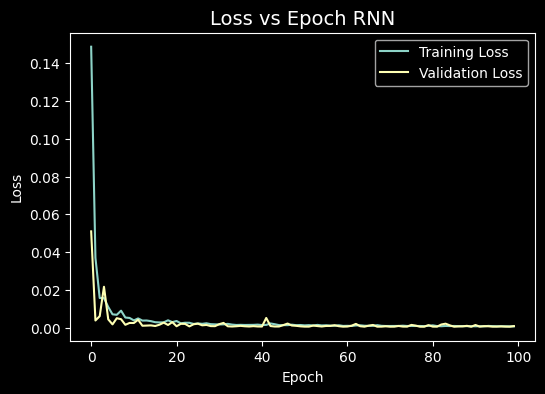

In [46]:
# Tentukan batas atas Y berdasarkan nilai maksimum loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch RNN', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save Training Model RNN

In [30]:
# Nama folder untuk menyimpan hasil
folder_name = "training_results"
os.makedirs(folder_name, exist_ok=True)  # Buat folder jika belum ada

# Simpan loss ke CSV
history_data = {
    "epoch": list(range(1, len(history.history["loss"]) + 1)),
    "training_loss": history.history["loss"],
    "validation_loss": history.history["val_loss"]
}
df = pd.DataFrame(history_data)
csv_path = os.path.join(folder_name, "RNN_loss_history.csv")
df.to_csv(csv_path, index=False)
print(f"Hasil training_result telah disimpan di {folder_name}!")

Hasil training_result telah disimpan di training_results!


## LSTM Model

### Fungsi Membuat Hyperparameter RandomizedSearchCV LSTM

In [31]:
def build_model_lstm(n_units=None, n_layers=None, dropout_rate=None, learning_rate=None):
    tf.random.set_seed(SEED)
    model = Sequential()
    model.add(tf.keras.Input(shape=(x_train.shape[1], 1)))  # Definisikan input layer

    # Layer pertama harus mempertimbangkan jumlah layer yang ada
    return_seq = True if n_layers > 1 else False
    model.add(LSTM(units=n_units, activation="tanh", return_sequences=return_seq))
    model.add(Dropout(dropout_rate))  # Dropout setelah layer pertama
    
    # Menambahkan additional LSTM layers sesuai jumlah layer yang ditentukan
    for i in range(1, n_layers):
        return_seq = i < (n_layers - 1)  # Hanya sebelum layer terakhir pakai return_sequences=True
        model.add(LSTM(units=n_units, activation="tanh", return_sequences=return_seq))
        model.add(Dropout(dropout_rate))  # Dropout setelah setiap LSTM layer
    
    # Menambahkan output layer
    model.add(Dense(units=1))

    # Konfigurasi optimizer dan loss function serta compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

In [32]:
# Membungkus model dalam KerasRegressor dengan parameter yang akan dituning
model_lstm = KerasRegressor(model=build_model_lstm, verbose=0)

# Menentukan ruang pencarian hyperparameter
param_distributions = {
    'model__n_units': [64, 128, 256],
    'model__n_layers': [1, 2],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0001],
    'epochs': [100],
    'batch_size': [64]
}

In [35]:
# Konfigurasi logging untuk menampilkan progress pencarian
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_lstm, 
    param_distributions=param_distributions, 
    n_iter=20,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=1,
    cv=5,
    random_state=SEED
)

# Fungsi early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.00001,
    verbose=1,
    restore_best_weights=True
)

fit_params = {
    "callbacks": [early_stopping]
}

# Catat waktu mulai
start_time = time.time()

# Jalankan pencarian hyperparameter
logging.info("Memulai RandomizedSearchCV...")
random_search.fit(x_train, y_train, **fit_params)
logging.info("Pencarian hyperparameter selesai.")

# Hitung durasi
end_time = time.time()
elapsed_time = end_time - start_time

# Konversi ke jam, menit, dan detik
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

logging.info(f"Durasi pencarian: {int(hours)} jam {int(minutes)} menit {int(seconds)} detik")

# Menampilkan cv_results
cv_results = random_search.cv_results_
logging.info("\nCV Results:")
for mean_score, params, rank in zip(cv_results['mean_test_score'], cv_results['params'], cv_results['rank_test_score']):
    logging.info(f"Rank: {rank} - Params: {params} - Mean Test Score: {mean_score:.6f}")

# Menampilkan hyperparameter terbaik
logging.info(f"\nBest Hyperparameters: {random_search.best_params_}")
logging.info(f"Best Score: {random_search.best_score_}")


2025-04-14 20:48:52,597 - Memulai RandomizedSearchCV...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2025-04-14 22:46:44,419 - Pencarian hyperparameter selesai.
2025-04-14 22:46:44,429 - Durasi pencarian: 1 jam 57 menit 51 detik
2025-04-14 22:46:44,430 - 
CV Results:
2025-04-14 22:46:44,434 - Rank: 12 - Params: {'model__n_units': 256, 'model__n_layers': 1, 'model__learning_rate': 0.0001, 'model__dropout_rate': 0.2, 'epochs': 100, 'batch_size': 64} - Mean Test Score: -0.000384
2025-04-14 22:46:44,434 - Rank: 11 - Params: {'model__n_units': 128, 'model__n_layers': 2, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.3, 'epochs': 100, 'batch_size': 64} - Mean Test Score: -0.000364
2025-04-14 22:46:44,435 - Rank: 7 - Params: {'model__n_units': 64, 'model__n_layers': 1, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.2, 'epochs': 100, 'batch_size': 64} - Mean Test Score: -0.000276
2025-04-14 22:46:44,435 - Rank: 17 - Params: {'model__n_units': 64, 'model__n_layers': 1, 'model__learning_rate': 0.0001, 'model__dropout_rate': 0.3, 'epochs': 100, 'batch_size': 64} - Mean Test Sco

### Save Hasil RandomizedSearchCV LSTM

In [ ]:
import joblib

# Nama folder dan file
folder_name = "hyperparameter_results"
file_name = "LSTM_random_search_results.pkl"
file_path = os.path.join(folder_name, file_name)

# Pastikan folder ada
os.makedirs(folder_name, exist_ok=True)

# Simpan semua hasil pencarian hyperparameter, best parameters, dan best score
search_results = {
    "cv_results": random_search.cv_results_,
    "best_params": random_search.best_params_,
    "best_score": random_search.best_score_,
}

# Simpan ke file pickle
joblib.dump(search_results, file_path)
print(f"Semua hasil pencarian hyperparameter telah disimpan di {file_path}!")


### Load Model Terbaik LSTM

In [33]:
# Gunakan kembali path yang sama
folder_name = "hyperparameter_results"
file_name = "LSTM_random_search_results.pkl"
file_path = os.path.join(folder_name, file_name)

# Load dari file
search_results = joblib.load(file_path) 

# Ambil hasil-hasil penting
best_params = search_results['best_params']
best_score = search_results['best_score']
cv_results = search_results['cv_results']

# Print untuk cek
print("Best Parameters:", best_params)
print("Best Score (neg MSE):", best_score)

Best Parameters: {'model__n_units': 256, 'model__n_layers': 1, 'model__learning_rate': 0.001, 'model__dropout_rate': 0.2, 'epochs': 100, 'batch_size': 64}
Best Score (neg MSE): -0.0001866244172126542


In [34]:
# Menggunakan model terbaik
best_params = best_params
best_model_LSTM = build_model_lstm(
    n_units=best_params['model__n_units'],
    n_layers=best_params['model__n_layers'],
    dropout_rate=best_params['model__dropout_rate'],
    learning_rate=best_params['model__learning_rate']
)

# Menampilkan summary model
logging.info("Menampilkan Model Arsitektur LSTM Summary:")
best_model_LSTM.summary()  # Mengakses model Keras

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,449 (1.01 MB)

 Trainable params: 264,449 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

### Training Model LSTM

In [35]:
# Pastikan direktori checkpoint ada
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)  # Membuat direktori jika belum ad

# Path untuk menyimpan model terbaik
checkpoint_model_path = os.path.join(checkpoint_dir, 'best_LSTM_model.keras')

# Callback untuk menyimpan **model lengkap terbaik**
checkpoint_model = ModelCheckpoint(
    filepath=checkpoint_model_path, # Menyimpan model pada path ini
    monitor='val_loss',       # Memantau loss pada data validasi
    mode='min',               # Menyimpan model dengan loss terkecil
    save_best_only=True,      # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan model lengkap (termasuk struktur dan bobot)
    verbose=2                 # Menampilkan progres penyimpanan model
)


In [ ]:
# Latih model dengan hyperparameter terbaik
history2 = best_model_LSTM.fit(
    x_train, y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_model], 
    verbose=1
)

Epoch 1/100
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0503
Epoch 1: val_loss improved from inf to 0.00196, saving model to model_checkpoints\best_LSTM_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0487 - val_loss: 0.0020
Epoch 2/100
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0011
Epoch 2: val_loss improved from 0.00196 to 0.00135, saving model to model_checkpoints\best_LSTM_model.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/100
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 8.4307e-04
Epoch 3: val_loss did not improve from 0.00135
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 8.4120e-04 - val_loss: 0.0016
Epoch 4/100
40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 9.5021e-04
Epoch 4: val_loss did not improve from 0.00135
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 9.4572e-04 - val_loss: 0.0016
Epoch 5/100
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 8.8886e-04
Epoch 5: val_loss improved from 0.00135 t

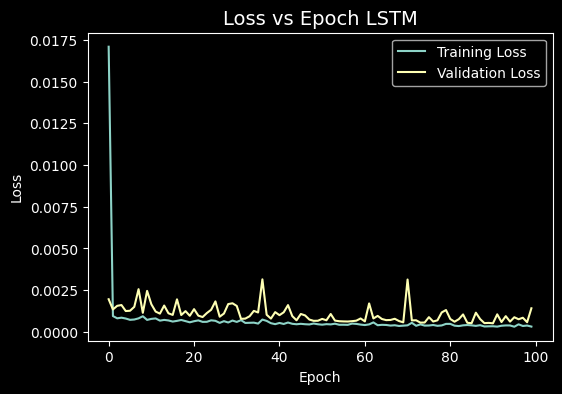

In [44]:
# Plot training loss dan validation loss
plt.figure(figsize=(6, 4))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch LSTM', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Save Training Model LSTM

In [38]:
# Nama folder untuk menyimpan hasil
folder_name = "training_results"
os.makedirs(folder_name, exist_ok=True)  # Buat folder jika belum ada

# Simpan loss ke CSV
history_data2 = {
    "epoch": list(range(1, len(history2.history["loss"]) + 1)),
    "training_loss": history2.history["loss"],
    "validation_loss": history2.history["val_loss"]
}
df = pd.DataFrame(history_data2)
csv_path = os.path.join(folder_name, "LSTM_loss_history.csv")
df.to_csv(csv_path, index=False)
print(f"Hasil training_result telah disimpan di {folder_name}!")

Hasil training_result telah disimpan di training_results!
